### 8-9. 프로젝트 : 다양한 OCR모델 비교하기

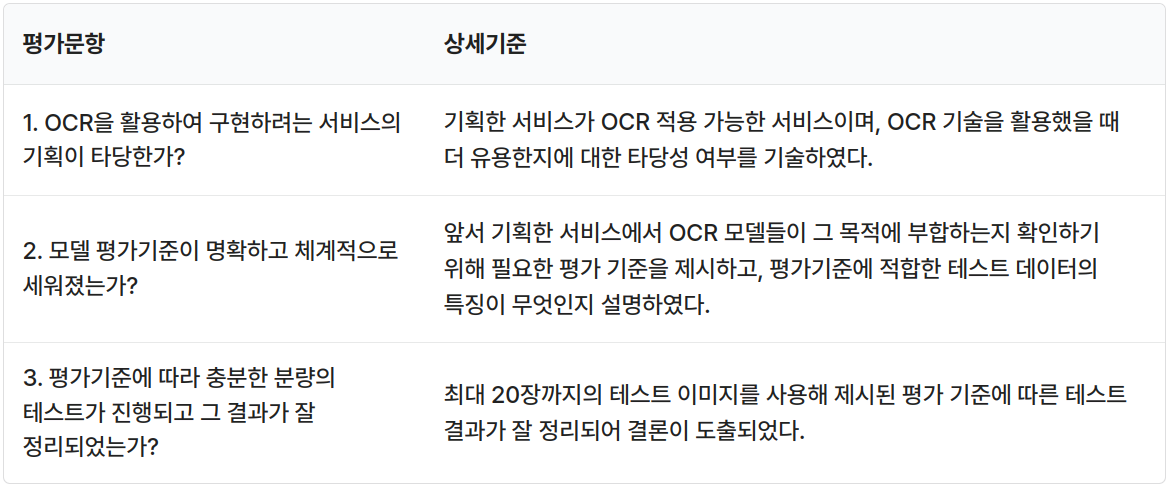




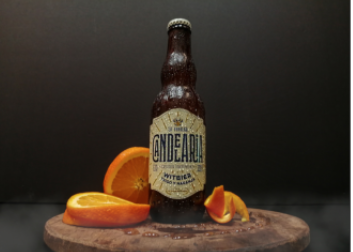



- 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았다.




- 지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 실전에 활용.




- OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아니다. 용도에 맞게 적절한 것을 선택하는것도 중요. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행. OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정.


###  keras-ocr- 프로젝트를 시작하기 전에 주요 라이브러리 불러오기,  버전 확인

In [13]:
import os
import glob
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as img

# keras-ocr
import keras_ocr

# tesseract
import pytesseract
from PIL import Image
from pytesseract import Output
import re

# Google OCR API
from google.cloud import vision
import io
from PIL import ImageDraw

pipeline = keras_ocr.pipeline.Pipeline()

print(keras_ocr.__version__)
print(pytesseract.__version__)

# pytesseract는 tesseract-ocr에 종속적. 아래 명령어를 통해 설치해야 할 수도 있다.
# !sudo apt install tesseract-ocr

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5
0.8.8
0.3.8


### Step1. 검증용 데이터셋 준비

- OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것. 
  위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 
  이미지 데이터를 검증해야 할 항목별로 고루 갖춰지는 것 중요.





- 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않게.





In [14]:
# HRP 
#import matplotlib.pyplot as plt
##import matplotlib.patches as patches Q 이거 필요?
#from PIL import Image
#import numpy as np # Q 이거 필요?

#from google.cloud import vision
#import io

#import keras_ocr
#import cv2

#import os
#import pytesseract
#from PIL import Image
#from pytesseract import Output

#import glob
#import easyocr # Q 이거 필요?

In [15]:
# 필요한 데이터셋 가져오기!
data_path = os.getenv('HOME')+'/aiffel/Going_Deeper/G-8 마트상품6개/'

images_path = glob.glob(data_path+"*.jpg")
images_path

['/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/atoq-1ufBhJcQc-U-unsplash.jpg',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/frances-newton-RbEOLEX__JE-unsplash.jpg',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/andrey-ilkevich-y1J53_wjmuY-unsplash.jpg',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/daniil-onischenko-fZzAjEi32a0-unsplash.jpg',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/matthew-ball-fg57cyzArZ0-unsplash.jpg',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/salman-sidheek-MOuMUQ-I6_Q-unsplash.jpg']

In [16]:
# 검증 이미지 준비 
fileEx = r'.jpg'
file_list = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.endswith(fileEx)]

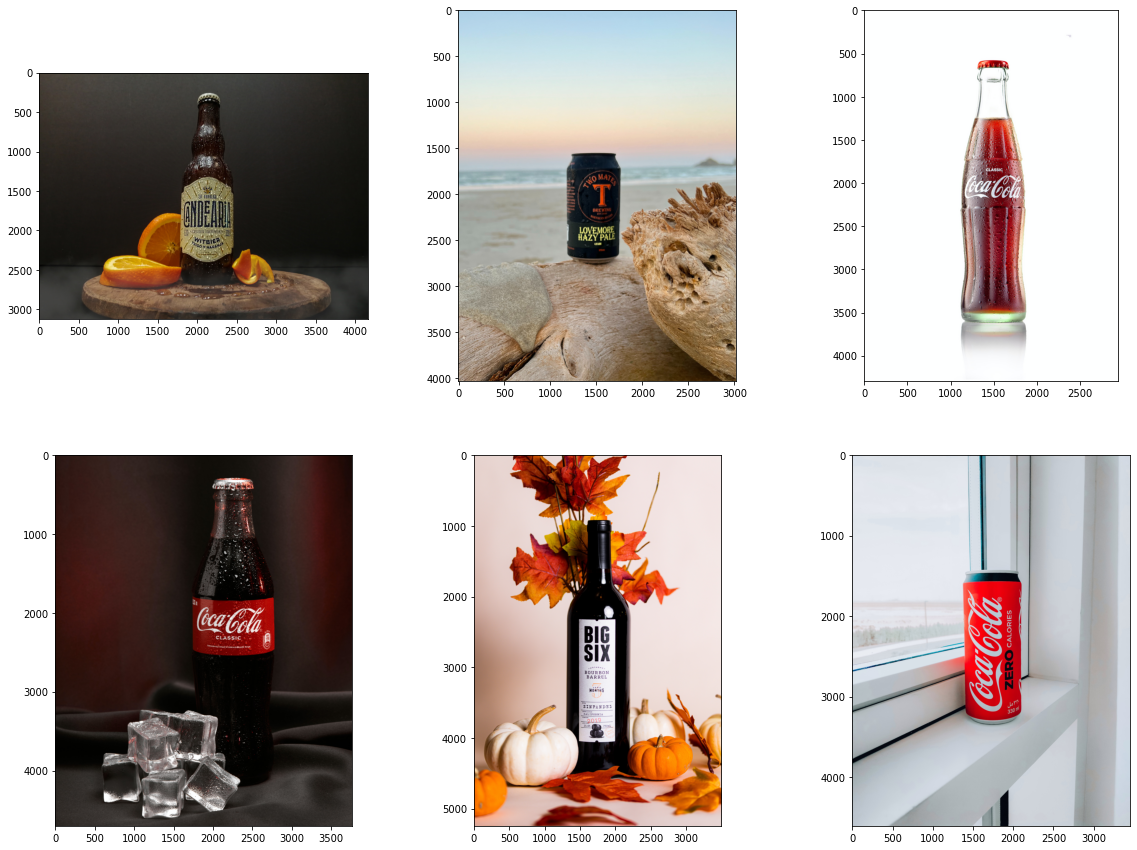

In [17]:
# 검증 이미지 출력 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

for i, ax in enumerate(axes.flatten()):
  image = img.imread(file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

### Step2 -1. keras-ocr 로 테스트 진행(Google OCR API는 선택 사항)


- keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할수 있게 해줌. 공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 <span style="background-color:#DCFFE4">CRAFT(Character Region Awareness for Text Detection) </span>를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용.




-keras-ocr 버전을 클라우드 쉘에서 확인 $ pip list | grep keras-ocr

필요한 라이브러리인 keras_ocr 과 인식 결과의 시각화를 위한 matplotlib.pyplot 를 불러옵. keras_ocr.pipeline.Pipeline() 는 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 <span style="background-color:#DCFFE4">미리 학습된 모델의 가중치(weight) </span>를 불러오게 됩. <span style="background-color:#DCFFE4">검출기와 인식기를 위한 가중치 하나씩 </span>을 불러오.

https://keras-ocr.readthedocs.io/en/latest/index.html 
keras_ocr 공식문서


In [18]:
images = [keras_ocr.tools.read(path) for path in images_path]
prediction_groups = [pipeline.recognize([path]) for path in images_path] # for in 뒤에 노드대로 img쓰면 iterable 에러남.images_path넣야됨. 

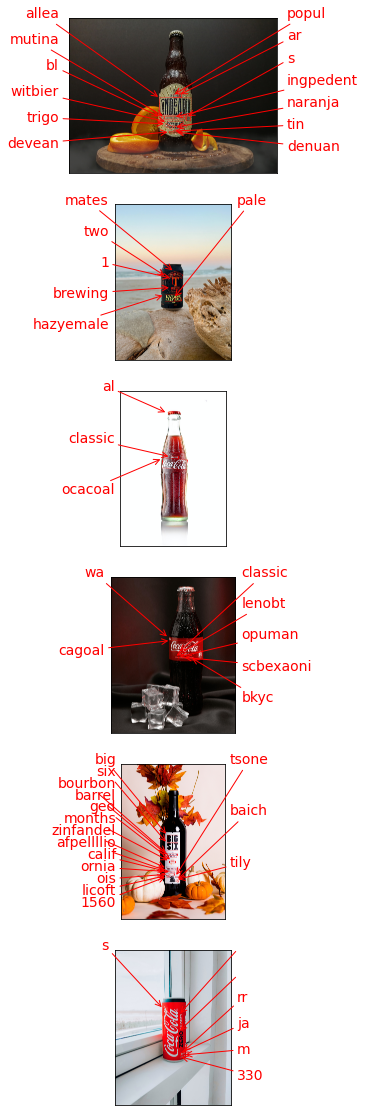

In [19]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax) 

#### keras-ocr 로 테스트 결과

- 마트상품 라벨의 상품명 분류 서비스엔 keras-ocr 적용하는건  부적절함. 꽤 큰 상품명도 확연하게 Recognition을 못하고 코카콜라 흰색 글씨, 투명한 병은 더욱 인식을 못함. 책제목이나 간판명같은  글자가 큰경우에나 적용하는게 적절하다.




### Step2 -2.  Tesseract 로 테스트 진행


- 테서랙트로 문자 검출하고 이미지 자르기 (detection) 테서랙트를 사용하면 한 번에 이미지 내의 문자검출과 인식. OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저.




In [20]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list 

In [21]:
data_path = os.getenv('HOME')+'/aiffel/Going_Deeper/G-8 마트상품6개/'
img_file_path = data_path + 'andrey-ilkevich-y1J53_wjmuY-unsplash.jpg'#테스트용 이미지 경로로 선택한 사진 파일명 1개 넣라. 

- crop_word_regions() 함수는 선택한 테스트 이미지를 받아서, 문자검출을 진행한후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴.




- Q 왜 이미지는 6개인데 14개줄씩 2덩이 왜 여러? ->  crop한 부분 부분들이 하나씩 png로 인식된것.

In [22]:
crop_word_regions(img_file_path, data_path)

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0001.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0002.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0003.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0004.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0005.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0006.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0007.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0008.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0009.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0010.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0011.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0012.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0013.png


['/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0001.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0002.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0003.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0004.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0005.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0006.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0007.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0008.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0009.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0010.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0011.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0012.png',
 '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0013.png']

In [23]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [24]:
img_ext='.jpg'
img_file_list = [img_file for img_file in os.listdir(data_path) if img_file.endswith(img_ext)]
img_file_list

['atoq-1ufBhJcQc-U-unsplash.jpg',
 'frances-newton-RbEOLEX__JE-unsplash.jpg',
 'andrey-ilkevich-y1J53_wjmuY-unsplash.jpg',
 'daniil-onischenko-fZzAjEi32a0-unsplash.jpg',
 'matthew-ball-fg57cyzArZ0-unsplash.jpg',
 'salman-sidheek-MOuMUQ-I6_Q-unsplash.jpg']

In [35]:
def get_img(): # 여러 이미지에서 한번에 문자를 추출하는 함수 
    data_path =os.getenv('HOME')+ '/aiffel/Going_Deeper/G-8 마트상품6개/'
    for img in glob.glob(data_path + '*.png'):
       # print(img)
        crop_word_regions(img, data_path)
        cropped_image_path_list = crop_word_regions(img, data_path)
        recognize_images(cropped_image_path_list)
        raw_img = Image.open(img)
        plt.imshow(raw_img)
        plt.show()
        print('========================================')

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
\

Done


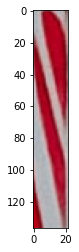

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
cece

Done


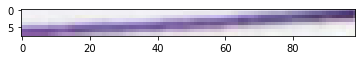

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
MONTHS

Done


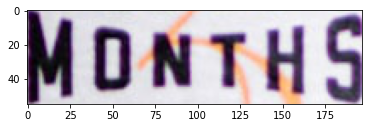

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
CALIFORNTA

Done


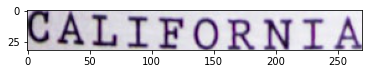

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
BARREL

Done


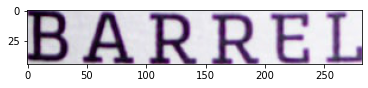

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
Th

Done


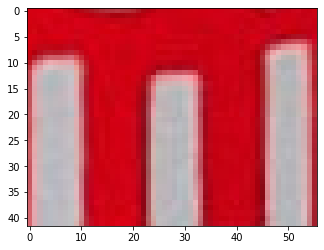

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
>

Done


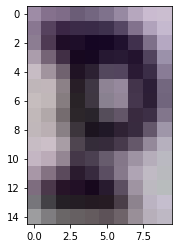

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
ZINFANDEL

Done


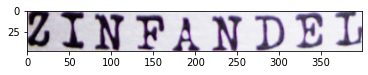

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
0

Done


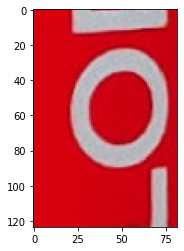

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
BOURBON

Done


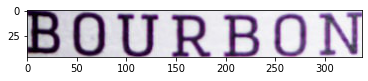

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0001.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0001.png
5

<

Done


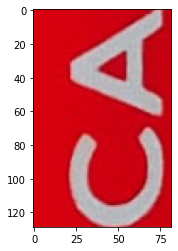

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
Y

Done


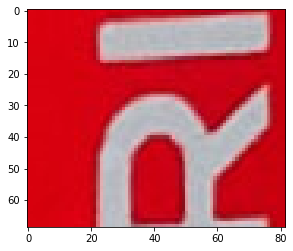

/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0000.png
VINTAGE

Done


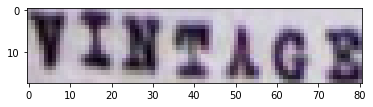

UnidentifiedImageError: cannot identify image file '/aiffel/aiffel/Going_Deeper/G-8 마트상품6개/0005.png'

In [36]:
get_img()

In [26]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
# recognize_images(cropped_image_path_list)

NameError: name 'cropped_image_path_list' is not defined

In [15]:
# output_dir = data_path + '/tesseract_output'

# tesseract_ocr_dict = {}
# for img_path, img_file in zip(images_path, img_file_list):
#     print(f'---------------{img_file}---------------')
#     cropped_image_dict = crop_word_regions(img_path, output_dir)
    
#     # 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
#     text_list = recognize_images(cropped_image_dict.keys())
#     tesseract_ocr_dict[img_file] = {'text_list': text_list, 'cropped_image_dict': cropped_image_dict}

---------------atoq-1ufBhJcQc-U-unsplash.jpg---------------
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개//tesseract_output/0000.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개//tesseract_output/0001.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개//tesseract_output/0002.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개//tesseract_output/0003.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개//tesseract_output/0004.png
/aiffel/aiffel/Going_Deeper/G-8 마트상품6개//tesseract_output/0005.png


AttributeError: 'list' object has no attribute 'keys'

In [ ]:
# def recognize_images(cropped_image_path_list):
#     custom_oem_psm_config = r'--oem 3 --psm 7'
    
#     for image_path in cropped_image_path_list:
#         image = Image.open(image_path)
#         recognized_data = pytesseract.image_to_string(
#             image, lang='eng',    # 한국어라면 lang='kor'
#             config=custom_oem_psm_config,
#             output_type=Output.DICT올 
#         )
#         print(recognized_data['text'])
#     print("Done") #효린꺼 는 여기까지. recognize__images(cropped_image_path_list) 이1줄은 없고 정퍼가 짜준거 1덩이로 스텝3에 표로 정리. 정퍼는 이덩이 자체도 없고 Value Error 난채 이미지출력으로 끝.
    #HRP는 tesseract 에 26번부터 코드 6 덩이 있고 1덩이끝  return cropped_image_dict, 2끝 return text_list 3끝 for문 돌리는등 4째부터 실행결과 올 array
    #들뿐인데 이걸보고 뭔 문자 recognition 판단 ? Step3. 테스트 결과 정리써논게 'Google OCR API'부터 긴 array끝에 글자인식 나온 이미지 46번 긴 array끝에 a문자인식 나옴
    # 스텝3에서 표로 OCR별 인식힌 글자들 표로 비교해놈. 현이 케라스는 줄 겨우, tesseract도 결과 없이 끝.

In [2]:
# tesseract_ocr_text_pos_list = []
# tesseract_ocr_text_list = []
# for i, (img_path, tesseract_ocr_result) in enumerate(tesseract_ocr_dict.items()):
#   tesseract_ocr_text_list.append([i, tesseract_ocr_result['text_list']])
#   tesseract_ocr_text_pos_list.append([i, list(tesseract_ocr_result['cropped_image_dict'].values())])

NameError: name 'tesseract_ocr_dict' is not defined

In [3]:
#tesseract_ocr_text_list # HRP가 46에 이코드 썼는데 30에서 정의 했음#

[]

In [24]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
#recognize_images(cropped_image_path_list)

NameError: name 'cropped_image_path_list' is not defined

In [ ]:
#opped_image_path_list = crop_word_regions(img_file_path, output_dir)

In [ ]:
# def detect_box(image_path):
#     filename = os.path.basename(image_path)
#     # read the image and get the dimensions
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     d = pytesseract.image_to_data(img, output_type=Output.DICT)
#     n_boxes = len(d['text'])

#     ## draw the bounding boxes on the image
#     for i in range(n_boxes):
#         if int(d['conf'][i]) > 1: ## confidence가 1 이상인 값들만 출력!
#             (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
#             img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
#             text = d['text'][i]
#             text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
#             cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
#                         1.5, (0, 0, 255), 3)
#     return img

In [ ]:
# def get_img_path_n_file_list(work_dir= 'drive/MyDrive/Colab Notebooks/ocr_python/images', img_ext='.jpg'):
#   img_path_list = [img_path for img_path in glob.glob(work_dir + '/*') if img_path.endswith(img_ext)]
#   img_file_list = [img_file for img_file in os.listdir(work_dir) if img_file.endswith(img_ext)]
#   return img_path_list, img_file_list

In [ ]:
# def detect_text(path):
#     """Detects text in the file."""
#     from google.cloud import vision
#     import io
#     client = vision.ImageAnnotatorClient()

#     with io.open(path, 'rb') as image_file:
#         content = image_file.read()
        
#     image = vision.Image(content=content)

#     response = client.text_detection(image=image)
#     texts = response.text_annotations

#     print('Texts:')
    
#     for text in texts:
#         print('"{}"'.format(text.description))

#     vertices = (['({},{})'.format(vertex.x, vertex.y)
#                  for vertex in text.bounding_poly.vertices])

#     print('bounds: {}'.format(','.join(vertices)))

#     if response.error.message:
#         raise Exception(
#             '{}\nFor more info on error messages, check: '
#             'https://cloud.google.com/apis/design/errors'.format(
#                 response.error.message))

### Step3. 테스트 결과 정리

 
 
|상품번호|keras-ocr|Tesseract|
|:---:|:---:|:---:|      
|1|  allea mutina bl wibier trigo devean popul ar s ingpedent naranja tin denuan                                                               |                                                                     |
|2| mates two 1 brewing hazyemale pale                                                                |                                                                     |
|3|   al classic ocacoal                                                               |                                                                     |
|4|  wa cogoal classic lenobt opuman scbexaoni bkyc                                                               |                                                                     |
|5|   big six bourbon barrel ged month zinfandel afpelllg california ois licoft 1560 tsone baich tily                                                              |     month california barrel zinfandel bourbon
vintage 6 s rr ja m 330 /                                                                |
|6| s rr ja m 330                                                                |   o ca                                                                   |
|결과정리|  Tesseract보다 문자인식 더 많이 했으나 필기체나 투명하거나 곡선의 병표면의 문자,  흰글씨는 문자 detection이 잘안됨.                                                           |   5번 상품 문자인식이 그나마 많을걸로 보아 유리, 캔위의 글자보다 종이에 인쇄된걸 더 detection 잘함. 나머지는 거의  detection 이 안됐음                                                                |

### Step4. 결과 분석과 결론 제시


- OCR 적용 서비스 인가 ? : 마트상품 라벨의 상품명 분류 서비스엔 keras-ocr과 Tesseract 둘다 적용하는건  무리가 있음. 꽤 큰 상품명도 확연하게 Recognition을 못하고 
  필기체일수록, 코카콜라 흰색 글씨, 투명한 병은 더욱 인식을 못함. 책제목이나 간판명같은  글자가 큰경우에나 적용하는게 적절하다.
  
  
  




### Reference

- https://blog.naver.com/kpostbank/221343765011 OCR 기술의 용도




- https://kin.naver.com/qna/detail.naver?d1id=1&dirId=10302&docId=393359576&qb=7Jqw67aE7YisIEdQVSDsgqzslpEg7ZmV7J247ZWY64qU67KV&enc=utf8&section=kin.ext&rank=1&search_sort=0&spq=0
 우분투 GPU 파악




- https://cloud.google.com/vision?hl=ko 구글 OCR API






- https://kimchangheon.tistory.com/166 Google Cloud Vision API 키 생성 및 저장하기

### 결론 및 회고

- 여러 사업 모델을 찾다가 'Drug Store에서 상품 라벨의 문자 검출과 인식'을 통해 '원활한 상품분류를 자동화하는 사업모델'로 정해 진행하다 Tesseract에서   약품류들 글자가 작아 문자 검출이 잘안돼 이미지들 다시 '마트 상품명 인식' 서비스로 바꿈. 간판이나 책표지는 글자는 크나 하는 사람들이 많아 그마나 큰 마트상품 음료캔등을 쟁행해봄.



- Google OCR API가 선택사항이긴 하나 까다롭더라도 Google OCR API를 시도해보고 싶어서 Google OCR API를 파악하는데 여기서 좀체로 진도가 안나가 
  총 초반 4일간 여러시도를 하다 keras-ocr, Tesseract만으로 test하기로함.
   
  
  
  
- 노드코드가  Tesseract를 수행하기에 한계있음. 많은 에러를 유발. 따라서 여러 시도를 하게되거 비례하는 에러 해결하는데 시간이 많이 들어감. 





- 수많은 겪은 오류들중에 그때 그때 생각난것만 일부 상단 Error 내용과 해결과정 정리를 해보았는데 함수 define 오류내용이 많음. 역시 Error를 해결하는 실력이 절실 ! 



|번호|Error 내용|해결 과정|
|:---:|:---:|:---:|      
|1|  name 'cropped_image_path_list' is not defined                        |노드, 깃헙4인 똑같은 코드고 위에서 볼게 없는데                    |
|2| tesseract된 text list 뽑아보려니 tesseract_ocr_text_list이 정의 안됐다  |위 코드덩이서 정의해주니 'tesseract_ocr_dict' is not defined    |
|3|'tesseract_ocr_dict' is not defined                                    |위 코드덩이서 'tesseract_ocr_dict' 정의해줌                     | 
|4|'list' object has no attribute 'keys'                                  | 다른것도 할께있어 시간제약상 'keys' 해결은 추후에                | 
|5| tesseract를 적용해본 결과 보는데서 에러 다수.며칠동안 갖은시도 다해봄 |진표님 도움으로 함수명들 동일하고 경로 바로잡고등 해서 인식한 결과 조금이라도 보임.



